In [1]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
from PIL import ImageFilter

import numpy as np
import pandas as pd
from datetime import datetime

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
import torchvision.models as models

print(torch.__version__)
print(torch.cuda.is_available())

1.7.0+cu101
True


# load data

In [2]:
fixed_length_str = 4
BATCH_SIZE = 1000

class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label 
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')

        img = img.filter(ImageFilter.BLUR)

        if self.transform is not None:
            img = self.transform(img)

        if self.img_label == None:
            return img
        else:
            # 原始SVHN中类别10为填充的数字X, 最多字符为4
            lbl = np.array(self.img_label[index], dtype=np.int)
            lbl = list(lbl)  + (fixed_length_str - len(lbl)) * [10]
            
            return img, torch.from_numpy(np.array(lbl[:fixed_length_str]))

    def __len__(self):
        return len(self.img_path)


train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

test_path = glob.glob('../input/mchar_test_a/*.png')
test_path.sort()
test_label = None


train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.RandomCrop((60, 120)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(10),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
                       transforms.Resize((60, 120)),
                    #    transforms.RandomCrop((60, 120)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=10, 
)

test_loader = torch.utils.data.DataLoader(
        SVHNDataset(test_path, test_label,
                   transforms.Compose([
                       transforms.Resize((68, 138)),
                       transforms.RandomCrop((64, 128)),
                    #    transforms.ColorJitter(0.3, 0.3, 0.2),
                    #    transforms.RandomRotation(5),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)

# model

In [3]:
class SVHN_Model2(nn.Module):
    def __init__(self):
        super(SVHN_Model2, self).__init__()
        # CNN提取特征模块
        # resnet18
        model_conv = models.resnet18(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])  # 去除最后一个fc layer
        self.cnn = model_conv
        # 
        # self.hd_fc1 = nn.Linear(512, 128)
        # self.hd_fc2 = nn.Linear(512, 128)
        # self.hd_fc3 = nn.Linear(512, 128)
        # self.hd_fc4 = nn.Linear(512, 128)
        # self.dropout_1 = nn.Dropout(0.25)
        # self.dropout_2 = nn.Dropout(0.25)
        # self.dropout_3 = nn.Dropout(0.25)
        # self.dropout_4 = nn.Dropout(0.25)
        # self.fc1 = nn.Linear(128, 11)
        # self.fc2 = nn.Linear(128, 11)
        # self.fc3 = nn.Linear(128, 11)
        # self.fc4 = nn.Linear(128, 11)
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)

        # feat1 = self.hd_fc1(feat)
        # feat2 = self.hd_fc2(feat)
        # feat3 = self.hd_fc3(feat)
        # feat4 = self.hd_fc4(feat)
        # feat1 = self.dropout_1(feat1)
        # feat2 = self.dropout_2(feat2)
        # feat3 = self.dropout_3(feat3)
        # feat4 = self.dropout_4(feat4)

        # c1 = self.fc1(feat1)
        # c2 = self.fc2(feat2)
        # c3 = self.fc3(feat3)
        # c4 = self.fc4(feat4)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)

        return c1, c2, c3, c4


model = SVHN_Model2().cuda()
model=nn.DataParallel(model)    # dp多卡跑代码
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
best_loss = 1000.0


train_loss_plot = list()
val_loss_plot = list()

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [4]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for step, (input, target) in enumerate(tqdm(train_loader)):
        input = input.cuda()
        target = target.type(torch.cuda.LongTensor)

        c0, c1, c2, c3 = model(input)
        loss = criterion(c0, target[:, 0]) + \
                criterion(c1, target[:, 1]) + \
                criterion(c2, target[:, 2]) + \
                criterion(c3, target[:, 3])
        loss /= (fixed_length_str*BATCH_SIZE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)


def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    # val_pred = []

    # 不计算梯度，也不进行反向传播
    with torch.no_grad():
        for step, (input, target) in enumerate(val_loader):
            input = input.cuda()
            target = target.type(torch.cuda.LongTensor)

            c0, c1, c2, c3 = model(input)

            loss = criterion(c0, target[:, 0]) + \
                    criterion(c1, target[:, 1]) + \
                    criterion(c2, target[:, 2]) + \
                    criterion(c3, target[:, 3])
            loss /= (fixed_length_str*BATCH_SIZE)
            val_loss.append(loss.item())

    #         output = np.concatenate([
    #                 c0.data.cpu().numpy(),
    #                 c1.data.cpu().numpy(),
    #                 c2.data.cpu().numpy(),
    #                 c3.data.cpu().numpy()], axis = 1)
    #         val_pred.append(output)

    # val_pred = np.vstack(val_pred)

    return np.mean(val_loss)


def predict(test_loader, model, tta=10):
    model.eval()
    test_pred_tta = None
    # TTA 次数
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            for input in test_loader:
                input = input.cuda()

                c0, c1, c2, c3 = model(input)
                output = np.concatenate([
                    c0.data.cpu().numpy(),
                    c1.data.cpu().numpy(),
                    c2.data.cpu().numpy(),
                    c3.data.cpu().numpy()], axis = 1)
                test_pred.append(output)
        
        test_pred = np.vstack(test_pred)
        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred
    
    return test_pred_tta

In [ ]:
# model.load_state_dict(torch.load('model.pt'))

# Train

In [6]:
t0 = datetime.now()

for epoch in range(10):
    print('Epoch: ', epoch)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss = validate(val_loader, model, criterion)
    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model.pt')
        
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)

print("\nvalidation min loss:", best_loss)
print("run time", datetime.now()-t0)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  0


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  1


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  2


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  3


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  4


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  5


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  6


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  7


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  8


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch:  9


100%|██████████| 30/30 [00:08<00:00,  3.55it/s]



validation min loss: 0.8732274174690247
run time 0:02:05.111206


In [7]:
print("train loss:\n", train_loss_plot)
print("val loss:\n", val_loss_plot)

train loss:
 [1.4165329416592916, 0.9196161806583405, 0.7459541837374369, 0.6565028329690298, 0.5982725481192271, 0.5550966858863831, 0.5204868078231811, 0.48749124904473623, 0.46375610133012135, 0.44068768521149954]
val loss:
 [1.3315188407897949, 1.0432603359222412, 0.9768576323986053, 0.9322441816329956, 0.9674450159072876, 0.9432250261306763, 0.9164713442325592, 0.8815783321857452, 0.8996983110904694, 0.8732274174690247]


# plot loss

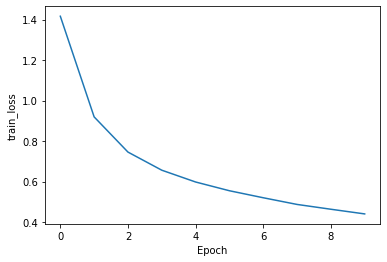

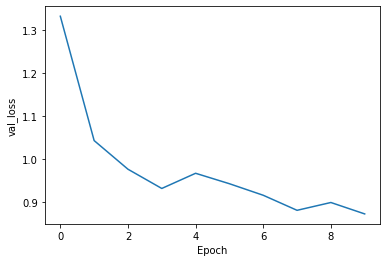

In [8]:
plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()


# test data

In [7]:
model.load_state_dict(torch.load('model.pt'))
test_pred_tta = predict(test_loader, model, tta=10)

test_pred_tta = torch.from_numpy(test_pred_tta).view(40000, fixed_length_str, -1)
predict_softmax = F.softmax(test_pred_tta, dim=2)
predict_label = predict_softmax.argmax(dim=2)

RuntimeError: Error(s) in loading state_dict for SVHN_Model1:
	Missing key(s) in state_dict: "cnn.0.bias", "cnn.3.weight", "cnn.3.bias". 
	Unexpected key(s) in state_dict: "hd_fc1.weight", "hd_fc1.bias", "hd_fc2.weight", "hd_fc2.bias", "hd_fc3.weight", "hd_fc3.bias", "hd_fc4.weight", "hd_fc4.bias", "cnn.6.0.conv1.weight", "cnn.6.0.bn1.weight", "cnn.6.0.bn1.bias", "cnn.6.0.bn1.running_mean", "cnn.6.0.bn1.running_var", "cnn.6.0.bn1.num_batches_tracked", "cnn.6.0.conv2.weight", "cnn.6.0.bn2.weight", "cnn.6.0.bn2.bias", "cnn.6.0.bn2.running_mean", "cnn.6.0.bn2.running_var", "cnn.6.0.bn2.num_batches_tracked", "cnn.6.0.downsample.0.weight", "cnn.6.0.downsample.1.weight", "cnn.6.0.downsample.1.bias", "cnn.6.0.downsample.1.running_mean", "cnn.6.0.downsample.1.running_var", "cnn.6.0.downsample.1.num_batches_tracked", "cnn.6.1.conv1.weight", "cnn.6.1.bn1.weight", "cnn.6.1.bn1.bias", "cnn.6.1.bn1.running_mean", "cnn.6.1.bn1.running_var", "cnn.6.1.bn1.num_batches_tracked", "cnn.6.1.conv2.weight", "cnn.6.1.bn2.weight", "cnn.6.1.bn2.bias", "cnn.6.1.bn2.running_mean", "cnn.6.1.bn2.running_var", "cnn.6.1.bn2.num_batches_tracked", "cnn.6.2.conv1.weight", "cnn.6.2.bn1.weight", "cnn.6.2.bn1.bias", "cnn.6.2.bn1.running_mean", "cnn.6.2.bn1.running_var", "cnn.6.2.bn1.num_batches_tracked", "cnn.6.2.conv2.weight", "cnn.6.2.bn2.weight", "cnn.6.2.bn2.bias", "cnn.6.2.bn2.running_mean", "cnn.6.2.bn2.running_var", "cnn.6.2.bn2.num_batches_tracked", "cnn.6.3.conv1.weight", "cnn.6.3.bn1.weight", "cnn.6.3.bn1.bias", "cnn.6.3.bn1.running_mean", "cnn.6.3.bn1.running_var", "cnn.6.3.bn1.num_batches_tracked", "cnn.6.3.conv2.weight", "cnn.6.3.bn2.weight", "cnn.6.3.bn2.bias", "cnn.6.3.bn2.running_mean", "cnn.6.3.bn2.running_var", "cnn.6.3.bn2.num_batches_tracked", "cnn.6.4.conv1.weight", "cnn.6.4.bn1.weight", "cnn.6.4.bn1.bias", "cnn.6.4.bn1.running_mean", "cnn.6.4.bn1.running_var", "cnn.6.4.bn1.num_batches_tracked", "cnn.6.4.conv2.weight", "cnn.6.4.bn2.weight", "cnn.6.4.bn2.bias", "cnn.6.4.bn2.running_mean", "cnn.6.4.bn2.running_var", "cnn.6.4.bn2.num_batches_tracked", "cnn.6.5.conv1.weight", "cnn.6.5.bn1.weight", "cnn.6.5.bn1.bias", "cnn.6.5.bn1.running_mean", "cnn.6.5.bn1.running_var", "cnn.6.5.bn1.num_batches_tracked", "cnn.6.5.conv2.weight", "cnn.6.5.bn2.weight", "cnn.6.5.bn2.bias", "cnn.6.5.bn2.running_mean", "cnn.6.5.bn2.running_var", "cnn.6.5.bn2.num_batches_tracked", "cnn.7.0.conv1.weight", "cnn.7.0.bn1.weight", "cnn.7.0.bn1.bias", "cnn.7.0.bn1.running_mean", "cnn.7.0.bn1.running_var", "cnn.7.0.bn1.num_batches_tracked", "cnn.7.0.conv2.weight", "cnn.7.0.bn2.weight", "cnn.7.0.bn2.bias", "cnn.7.0.bn2.running_mean", "cnn.7.0.bn2.running_var", "cnn.7.0.bn2.num_batches_tracked", "cnn.7.0.downsample.0.weight", "cnn.7.0.downsample.1.weight", "cnn.7.0.downsample.1.bias", "cnn.7.0.downsample.1.running_mean", "cnn.7.0.downsample.1.running_var", "cnn.7.0.downsample.1.num_batches_tracked", "cnn.7.1.conv1.weight", "cnn.7.1.bn1.weight", "cnn.7.1.bn1.bias", "cnn.7.1.bn1.running_mean", "cnn.7.1.bn1.running_var", "cnn.7.1.bn1.num_batches_tracked", "cnn.7.1.conv2.weight", "cnn.7.1.bn2.weight", "cnn.7.1.bn2.bias", "cnn.7.1.bn2.running_mean", "cnn.7.1.bn2.running_var", "cnn.7.1.bn2.num_batches_tracked", "cnn.7.2.conv1.weight", "cnn.7.2.bn1.weight", "cnn.7.2.bn1.bias", "cnn.7.2.bn1.running_mean", "cnn.7.2.bn1.running_var", "cnn.7.2.bn1.num_batches_tracked", "cnn.7.2.conv2.weight", "cnn.7.2.bn2.weight", "cnn.7.2.bn2.bias", "cnn.7.2.bn2.running_mean", "cnn.7.2.bn2.running_var", "cnn.7.2.bn2.num_batches_tracked", "cnn.1.weight", "cnn.1.bias", "cnn.1.running_mean", "cnn.1.running_var", "cnn.1.num_batches_tracked", "cnn.4.0.conv1.weight", "cnn.4.0.bn1.weight", "cnn.4.0.bn1.bias", "cnn.4.0.bn1.running_mean", "cnn.4.0.bn1.running_var", "cnn.4.0.bn1.num_batches_tracked", "cnn.4.0.conv2.weight", "cnn.4.0.bn2.weight", "cnn.4.0.bn2.bias", "cnn.4.0.bn2.running_mean", "cnn.4.0.bn2.running_var", "cnn.4.0.bn2.num_batches_tracked", "cnn.4.1.conv1.weight", "cnn.4.1.bn1.weight", "cnn.4.1.bn1.bias", "cnn.4.1.bn1.running_mean", "cnn.4.1.bn1.running_var", "cnn.4.1.bn1.num_batches_tracked", "cnn.4.1.conv2.weight", "cnn.4.1.bn2.weight", "cnn.4.1.bn2.bias", "cnn.4.1.bn2.running_mean", "cnn.4.1.bn2.running_var", "cnn.4.1.bn2.num_batches_tracked", "cnn.4.2.conv1.weight", "cnn.4.2.bn1.weight", "cnn.4.2.bn1.bias", "cnn.4.2.bn1.running_mean", "cnn.4.2.bn1.running_var", "cnn.4.2.bn1.num_batches_tracked", "cnn.4.2.conv2.weight", "cnn.4.2.bn2.weight", "cnn.4.2.bn2.bias", "cnn.4.2.bn2.running_mean", "cnn.4.2.bn2.running_var", "cnn.4.2.bn2.num_batches_tracked", "cnn.5.0.conv1.weight", "cnn.5.0.bn1.weight", "cnn.5.0.bn1.bias", "cnn.5.0.bn1.running_mean", "cnn.5.0.bn1.running_var", "cnn.5.0.bn1.num_batches_tracked", "cnn.5.0.conv2.weight", "cnn.5.0.bn2.weight", "cnn.5.0.bn2.bias", "cnn.5.0.bn2.running_mean", "cnn.5.0.bn2.running_var", "cnn.5.0.bn2.num_batches_tracked", "cnn.5.0.downsample.0.weight", "cnn.5.0.downsample.1.weight", "cnn.5.0.downsample.1.bias", "cnn.5.0.downsample.1.running_mean", "cnn.5.0.downsample.1.running_var", "cnn.5.0.downsample.1.num_batches_tracked", "cnn.5.1.conv1.weight", "cnn.5.1.bn1.weight", "cnn.5.1.bn1.bias", "cnn.5.1.bn1.running_mean", "cnn.5.1.bn1.running_var", "cnn.5.1.bn1.num_batches_tracked", "cnn.5.1.conv2.weight", "cnn.5.1.bn2.weight", "cnn.5.1.bn2.bias", "cnn.5.1.bn2.running_mean", "cnn.5.1.bn2.running_var", "cnn.5.1.bn2.num_batches_tracked", "cnn.5.2.conv1.weight", "cnn.5.2.bn1.weight", "cnn.5.2.bn1.bias", "cnn.5.2.bn1.running_mean", "cnn.5.2.bn1.running_var", "cnn.5.2.bn1.num_batches_tracked", "cnn.5.2.conv2.weight", "cnn.5.2.bn2.weight", "cnn.5.2.bn2.bias", "cnn.5.2.bn2.running_mean", "cnn.5.2.bn2.running_var", "cnn.5.2.bn2.num_batches_tracked", "cnn.5.3.conv1.weight", "cnn.5.3.bn1.weight", "cnn.5.3.bn1.bias", "cnn.5.3.bn1.running_mean", "cnn.5.3.bn1.running_var", "cnn.5.3.bn1.num_batches_tracked", "cnn.5.3.conv2.weight", "cnn.5.3.bn2.weight", "cnn.5.3.bn2.bias", "cnn.5.3.bn2.running_mean", "cnn.5.3.bn2.running_var", "cnn.5.3.bn2.num_batches_tracked". 
	size mismatch for cnn.0.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([16, 3, 3, 3]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([11, 128]) from checkpoint, the shape in current model is torch.Size([11, 672]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([11, 128]) from checkpoint, the shape in current model is torch.Size([11, 672]).
	size mismatch for fc3.weight: copying a param with shape torch.Size([11, 128]) from checkpoint, the shape in current model is torch.Size([11, 672]).
	size mismatch for fc4.weight: copying a param with shape torch.Size([11, 128]) from checkpoint, the shape in current model is torch.Size([11, 672]).

In [ ]:
def concat(*kw):
    result = ""
    for i in kw:
        result += str(i)
    return int(result)

submit = list()
for label in predict_label.numpy(): 
     submit.append(concat(*label[label<10]))


df_submit = pd.read_csv('../input/mchar_sample_submit_A.csv')
df_submit['file_code'] = submit
df_submit.to_csv('submit.csv', index=None)